# Anomaly Screening Applying Pseudo-wells (ASAP)

Stavanger Machine Learning Hackathon 18-19 September, 2018.

Project page: <https://events.agilescientific.com/project/asap>

## Pseudowell creation

This notebook shows how to:

* read well data;
* simplify elastic logs by "blocking" (i.e., replacing the natural, high-frequency variations of the recorded logs, with a constant value averaged over certain intervals of interest);
* create pseudo-logs by modifying blocked logs within reservoir section to simulate different conditions of fluid content, porosity and thickness following a given rock physics model;
* creating near and far-offset synthetic seismograms using as inputs the above pseudo-logs;
* output synthetic seismograms to be fed into notebook #2 (seismic data analysis via ML).

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bruges as b
import asap_library as hl
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

We first read in well data from Per Avseth's [open dataset distributed with the first edition of QSI (Quantitative Seismic Interpretation)](https://srb.stanford.edu/quantitative-seismic-interpretation).

Well 2 corresponds to the Glitne well 15/5-5 drilled in 1995. Well 5 is 15/5-6 (1997) and well 3 is 15/5-3. For all the informations related to these wells check [NPD's Factpages](http://factpages.npd.no/factpages/).

In [4]:
w2=pd.read_csv('qsiwell2.csv', index_col=0)
w3=pd.read_csv('qsiwell3.csv', index_col=0)
w5=pd.read_csv('qsiwell5.csv', index_col=0)

wells=    [ w2,       w3,       w5]
names=     ['15/5-5','15/5-3', '15/5-6']

In [9]:
for i in range(w2.columns.size):
    print('Log {} = {}'.format(i,w2.columns[i]))

Log 0 = VP
Log 1 = VS
Log 2 = RHO_OLD
Log 3 = GR
Log 4 = NPHI
Log 5 = RHO
Log 6 = SWE
Log 7 = SWX
Log 8 = VPVS
Log 9 = IP
Log 10 = IS
Log 11 = VSH
Log 12 = RHOm
Log 13 = RHOf
Log 14 = PHIE


This is again well 15/5-5; this is the version with "correct" porosity and fluid-replaced logs used during the hackathon:

In [46]:
well=pd.read_csv('15_5-5.dat', index_col=0)

Build a simple Pandas dataframe with the most relevant stratigraphic markers (Lista Fm. is the caprock shale and Heimdal Fm. is the reservoir sand):

In [16]:
tops_w2={'Lista': 2127, 'Heimdal': 2154}
tops_w3={'Lista': 2153, 'Heimdal': 2180}
tops_w5={'Lista': 2145, 'Heimdal': 2172}
tops=pd.DataFrame()
for i,val in enumerate([tops_w2,tops_w3,tops_w5]):
    tempdf=pd.DataFrame.from_dict(val, orient='index')
    tempdf.columns=[names[i]]
    tops=pd.concat([tops, tempdf],axis=1)

Summary plot of most relevant logs plus stratigraphic markers:

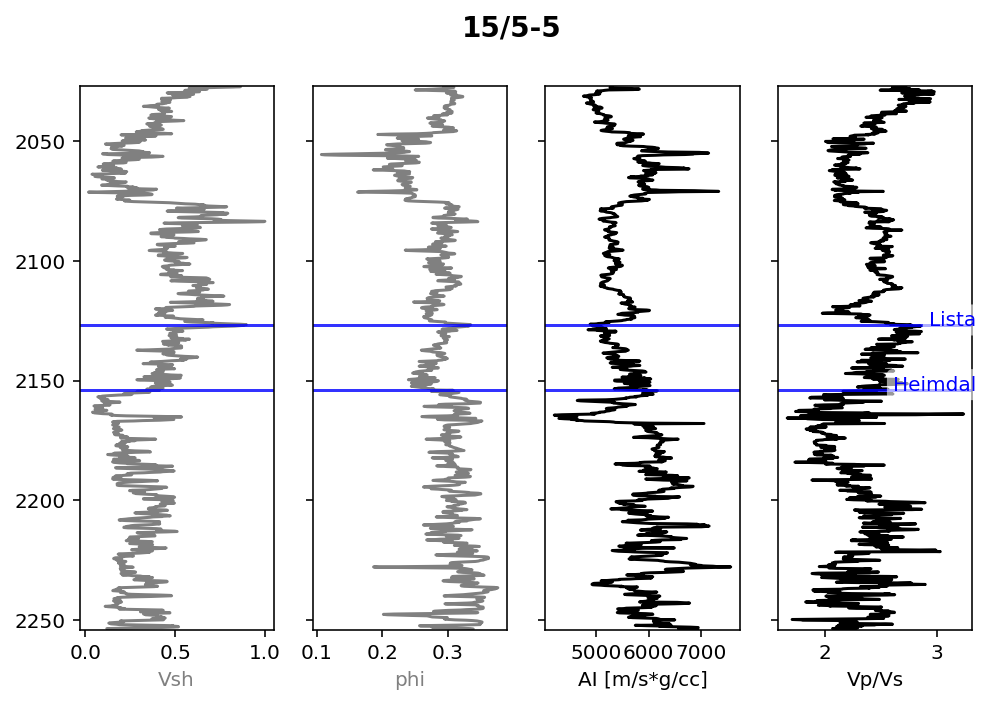

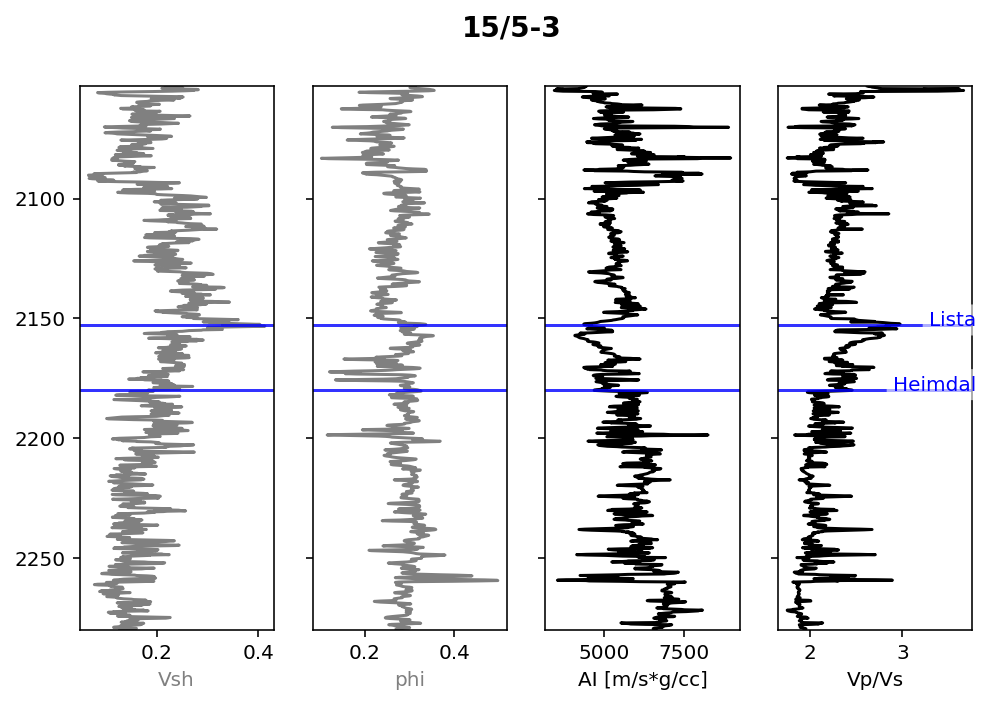

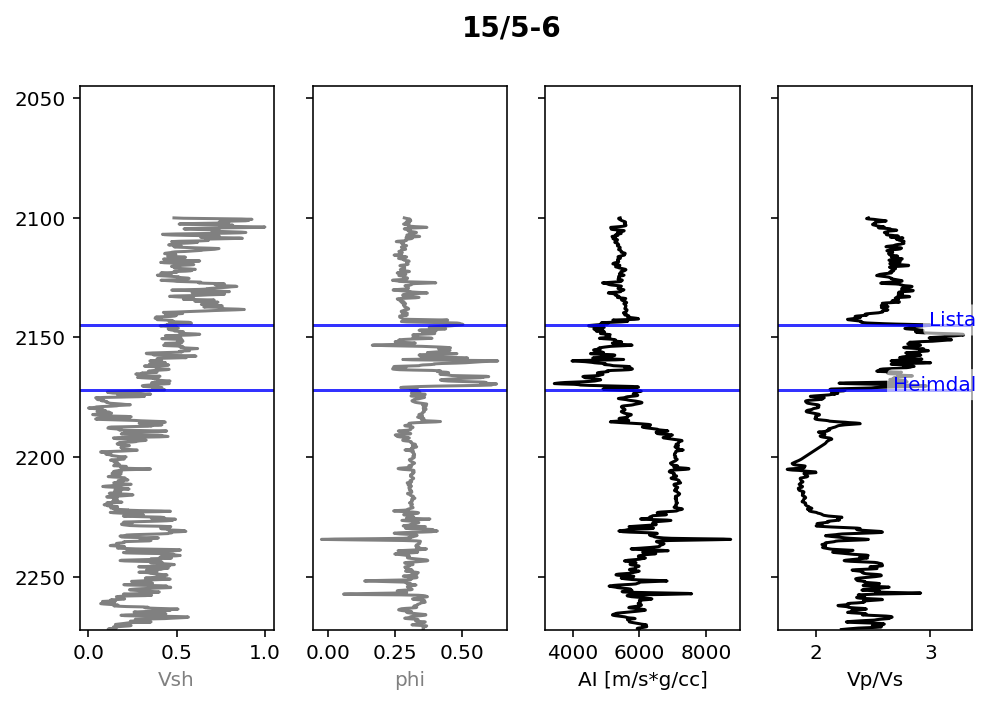

In [41]:
for i,p in enumerate(wells):
    z1 = tops[names[i]]['Lista']-100
    z2 = tops[names[i]]['Heimdal']+100
    hl.quicklook(p,ztop=z1,zbot=z2,name=names[i],tops=tops[names[i]])
#     plt.savefig('FIGS/{}_original_wells.png'.format(names[i].replace('/','_')))

Log blocking; define 4 depths selecting 3 intervals, i.e. top block (caprock), central block (reservoir) and lowermost block. Then use the function `generate_wells` to do the actual blocking plus modify fluid saturation, porosity and thickness in the central block and consequently (based on a rock physics model defined elsewhere) also the elastic logs Vp, Vs, density.

`generate_wells` requires in input a Pandas dataframe containing fluid substituted logs called `VP_FRMB`, `VS_FRMB`, `RHO_FRMB`, `VP_FRMO`, `VS_FRMO`, `RHO_FRMO`. Also required is a basename used to build the output csv datafiles in this way:

    [basename]_Z[thickness]_Sw[saturation]_Por[porosity].dat

The range of variations computed are:

* thickness: between 0 and 60 meters, step 20
* water saturation: between 0 and 1, step 0.25
* porosity: -10%, -5%, 0% and +5% of input porosity

_We need to include the rock physics model and link the results to the actual modifications computed within this function; also make a plot or two of this rpm._

In [62]:
top_blocks = [2050,2154,2200,2245]
hl.generate_wells(well,top_blocks,'TEST','SYNTWELLS')

To check the results, we load in a few blocky models and compare to the input well data using the function `blok_plot`:

In [63]:
blkmod1=pd.read_csv('SYNTWELLS/TEST_Z40_Sw100_Por20', index_col=0)
blkmod2=pd.read_csv('SYNTWELLS/TEST_Z40_Sw100_Por35', index_col=0)
blkmod3=pd.read_csv('SYNTWELLS/TEST_Z20_Sw100_Por35', index_col=0)

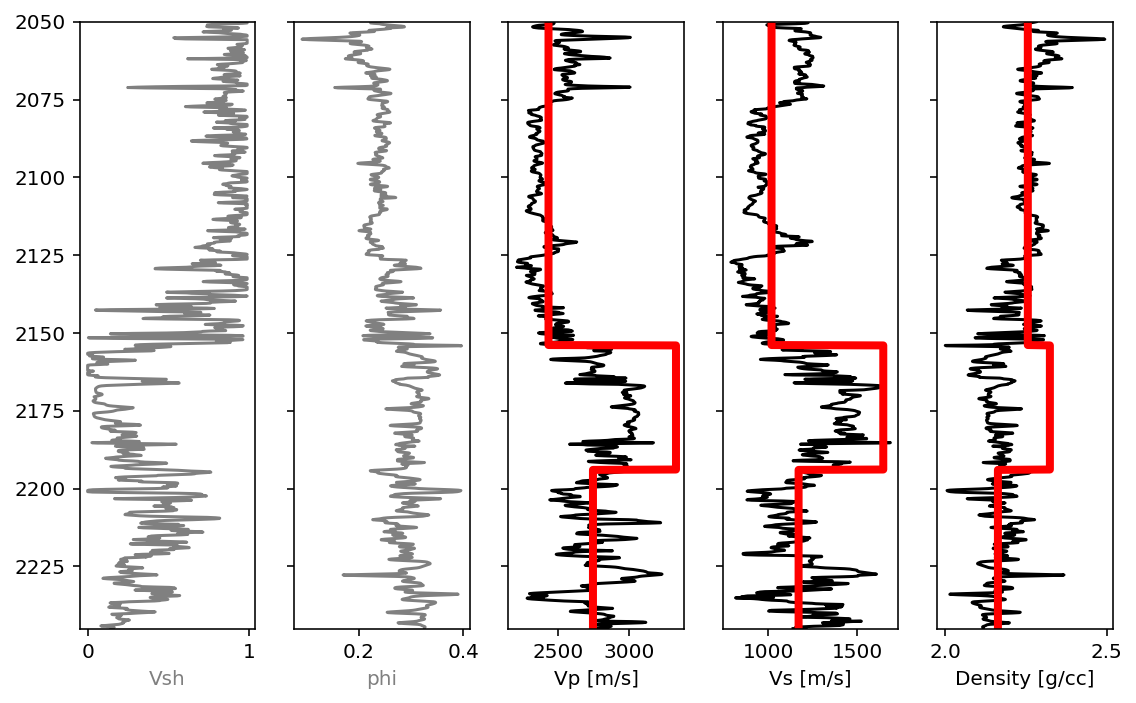

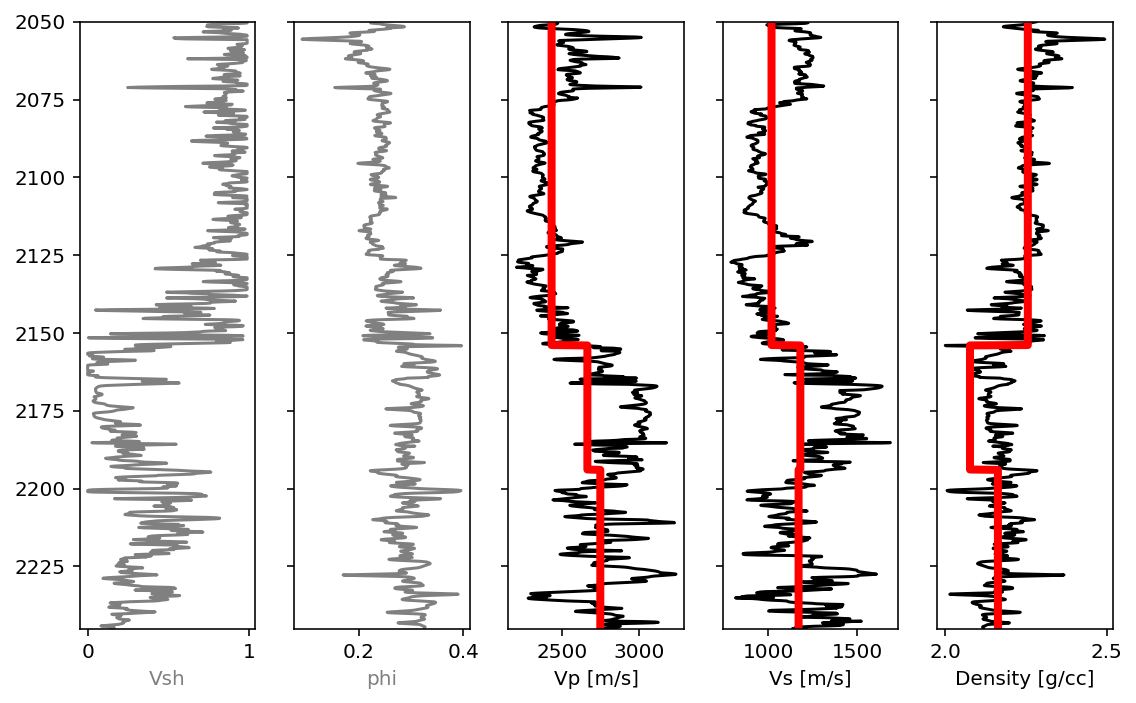

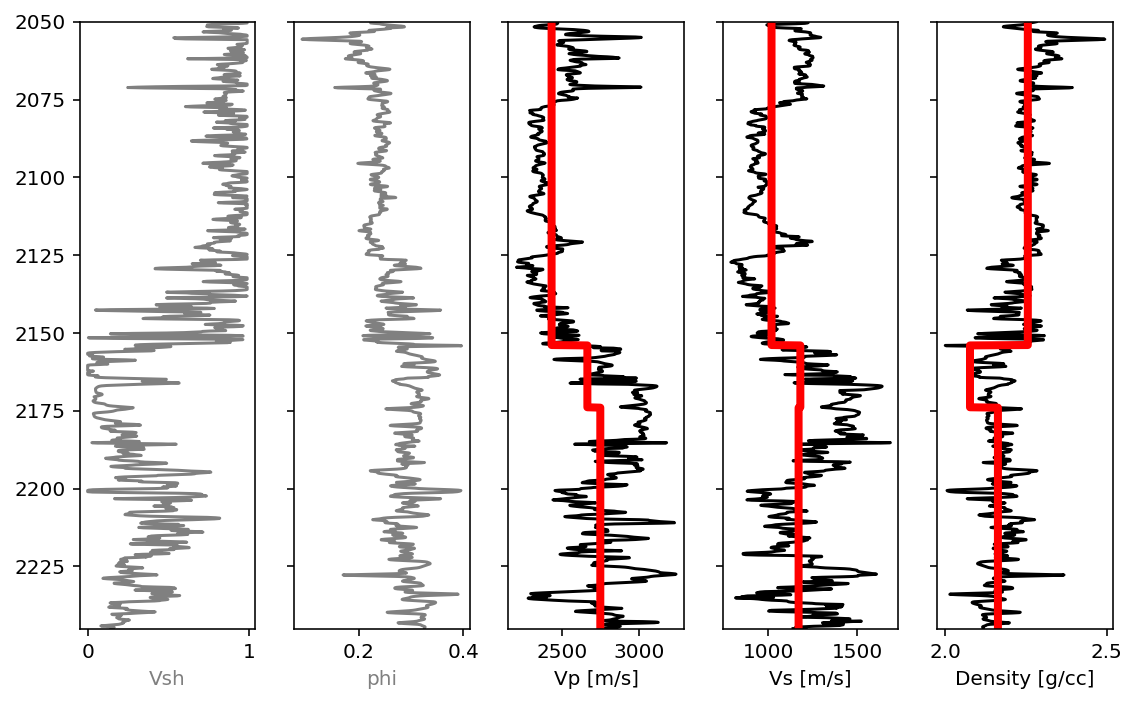

In [65]:
hl.blok_plot(well,blkmod1)
hl.blok_plot(well,blkmod2)
hl.blok_plot(well,blkmod3)

define forward modeling parameters:

* sample rate: 4 ms
* wavelet: Ricker 30 Hz
* angle range: 5 and 30 degrees to simulate Near and Far traces

In [66]:
dt=.004
wavl=b.filters.ricker(.25, dt, 30)
ang=np.linspace(5,30,2)

Calculate simple time-depth tables from sonic measurements with function `td`, then we store into `topres_<well>` the top Heimdal converted to two-way-times.

In [67]:
tdr_w2=hl.td(w2,KB=26,WD=109)
topres_w2=hl.get_twt(tdr_w2,tops['15/5-5']['Heimdal'])

tdr_w3=hl.td(w3,KB=26,WD=109)
topres_w3=hl.get_twt(tdr_w2,tops['15/5-3']['Heimdal'])

tdr_w5=hl.td(w5,KB=26,WD=109)
topres_w5=hl.get_twt(tdr_w5,tops['15/5-6']['Heimdal'])

[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 2013.253 [m] = 2.495 [s]
[TD] computed twt scale range: 2.495-2.926 [s]
[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 200.150 [m] = 0.229 [s]
[TD] computed twt scale range: 0.229-3.625 [s]
[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 2100.072 [m] = 2.604 [s]
[TD] computed twt scale range: 2.604-2.754 [s]


Read in blocky pseudowells (previously created with `generate_wells`), converts them to two-way-time, create synthetic seismograms and output to Pandas dataframe:

Notes: the function `make_synt` will compute as many traces as they are defined in the array `ang` so ideally we can compute full-offset seismograms but for simplicity we just create two traces.

In [70]:
tdr, topres = tdr_w2, topres_w2

well_files = hl.get_well_files(wells_dir='SYNTWELLS', name='TEST')
t1=topres-0.048
t2=topres+0.208

In [72]:
megasynt = pd.DataFrame()
for ff in well_files:
    nn=pd.read_csv(ff, index_col=0)
    nnt,_,_ = hl.welltime(nn,tdr,dt=dt,qcplot=False)
    rc,synt=hl.make_synt(nnt,ang,wavl,method='aki')
    outdf = nnt[(nnt.index>=t1) & (nnt.index<=t2)].copy()
    it1=np.abs(nnt.index-t1).argmin()
    it2=np.abs(nnt.index-t2).argmin()
    synt_cut = synt[it1:it2,:]
    outdf['NEAR'] = synt_cut[:,0]
    outdf['FAR'] = synt_cut[:,1]
    outdf['WELL'] = ff[10:-16] # will pick up the well name
    outdf['ID'] = ff[-15:] 
    megasynt = megasynt.append(outdf)

The following changes the dtype of the two columns `WELL` and `ID` to _categorical_, which is not relevant for the current work, but may be in the future if we want to do some data-wrangling and plots in Pandas.

In [73]:
megasynt['WELL']=megasynt['WELL'].astype('category')
megasynt['ID']=megasynt['ID'].astype('category')

Output to `csv`:

In [74]:
megasynt.to_csv('syntdataset_TEST.csv')

Plots only a handful of pseudowell synthetics for QC (constant thickness 60m, constant porosity 35%, variable water saturation):

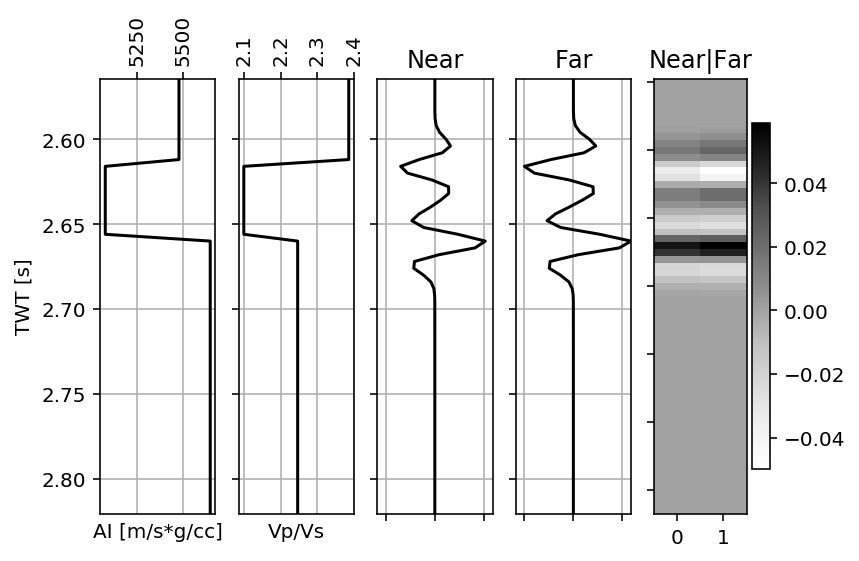

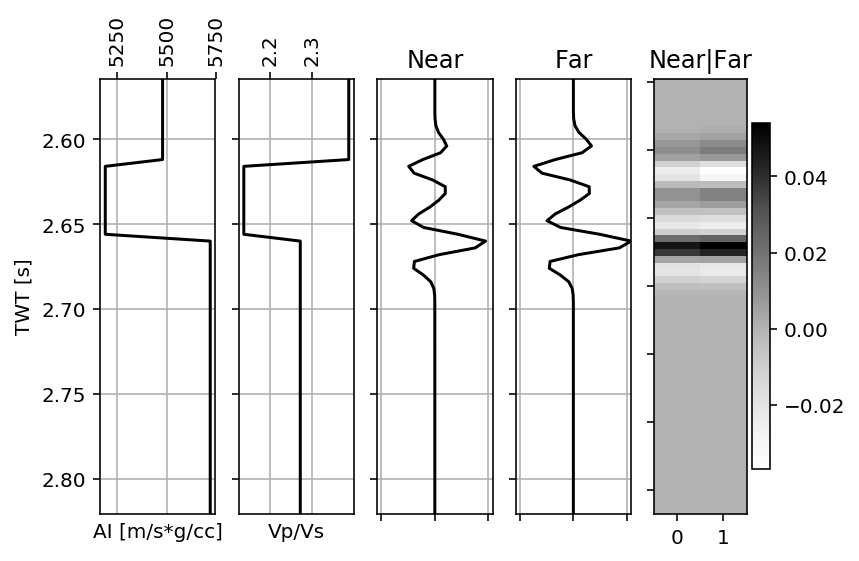

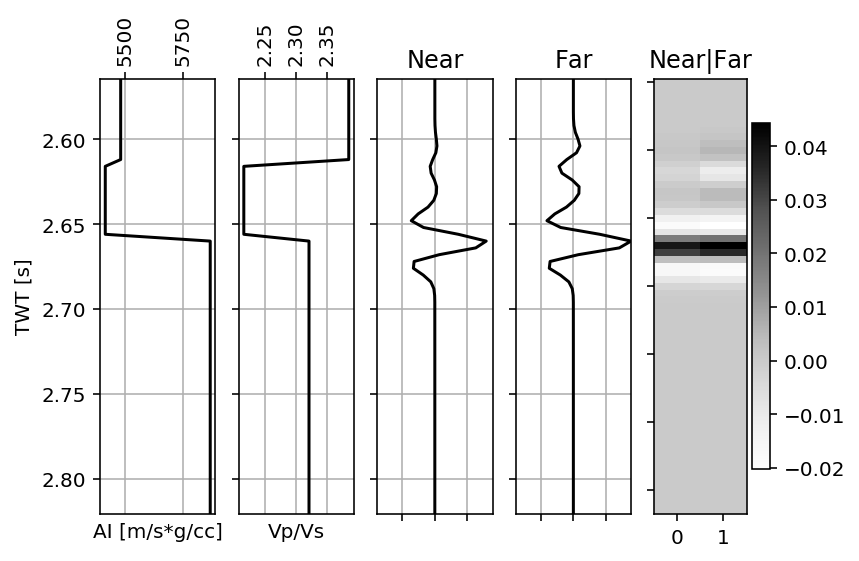

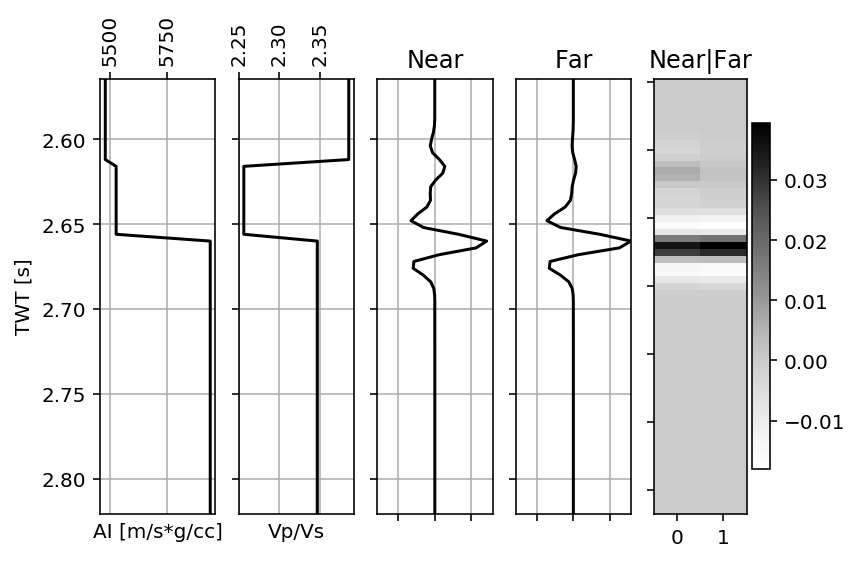

In [76]:
syntwells_dir='SYNTWELLS/'
test_files=[
'TEST_Z60_Sw000_Por35',
'TEST_Z60_Sw025_Por35',
'TEST_Z60_Sw075_Por35',
'TEST_Z60_Sw100_Por35']

for ff in test_files:
    nn=pd.read_csv(syntwells_dir+ff, index_col=0)
    nnt,_,_ = hl.welltime(nn,tdr_w2,dt=dt,tops=tops_w2,qcplot=False)
    rc,synt=hl.make_synt(nnt,ang,wavl,method='aki')
    hl.plot_synt(nnt,synt,t1,t2,20)
#     plt.savefig('FIGS/{}_synth_variable_Sw.png'.format(names[i].replace('/','_')))

Reads back in the entire Pandas dataframe with the pseudowells near and far traces and plots them stacked side by side like if it was a seismic section:

Text(0.5,1,'15/5-5 Far')

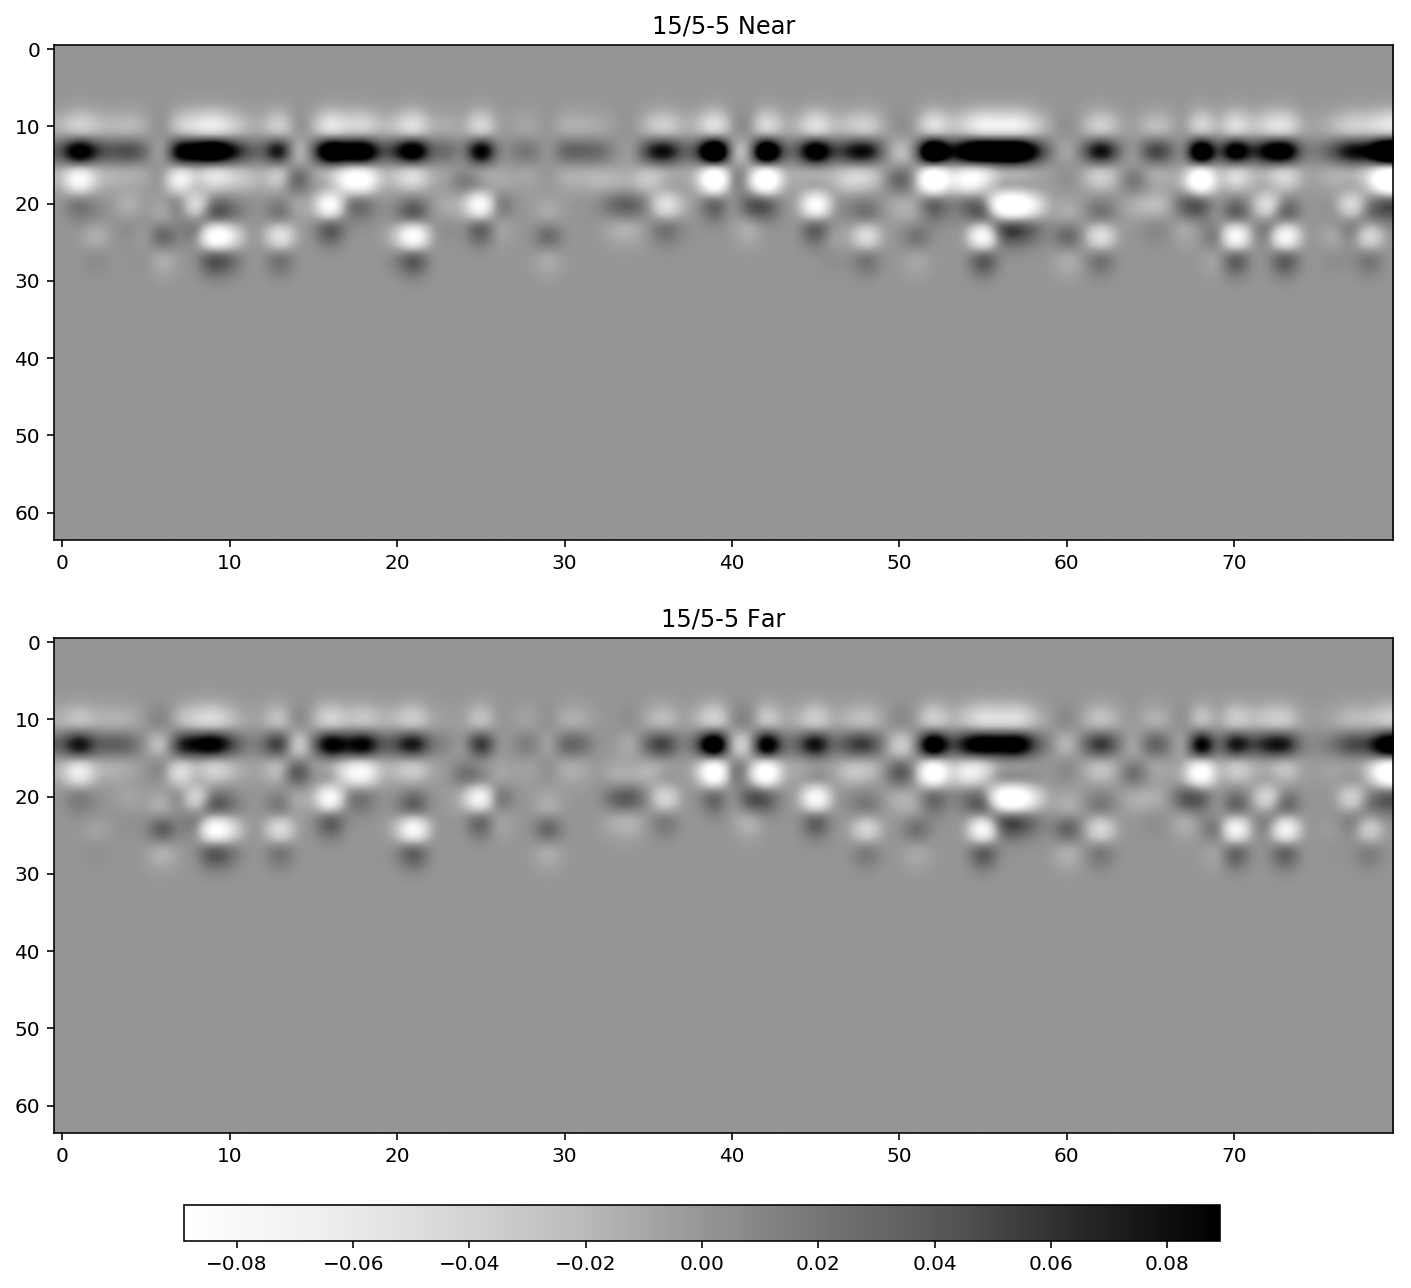

In [77]:
synt=pd.read_csv('syntdataset_TEST.csv')
nears, fars = hl.get_nears_fars(synt)

clip=abs(np.percentile([nears,fars], 0.80))

f,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,10))
im0=ax[0].imshow(nears,cmap='Greys',vmax=clip,vmin=-clip,aspect='auto', interpolation='bicubic')
im1=ax[1].imshow(fars,cmap='Greys',vmax=clip,vmin=-clip,aspect='auto', interpolation='bicubic')
cax = f.add_axes([0.2, 0.05, 0.6, 0.025])
f.colorbar(im0, cax=cax, orientation='horizontal')
ax[0].set_title('15/5-5 Near')
ax[1].set_title('15/5-5 Far')
# plt.savefig('FIGS/{}_synth_variable_Sw.png'.format(uuu))

Reads traces reconstructed by Lukas' ML algorithm and display them side by side with input traces to show the "denoising" effect:

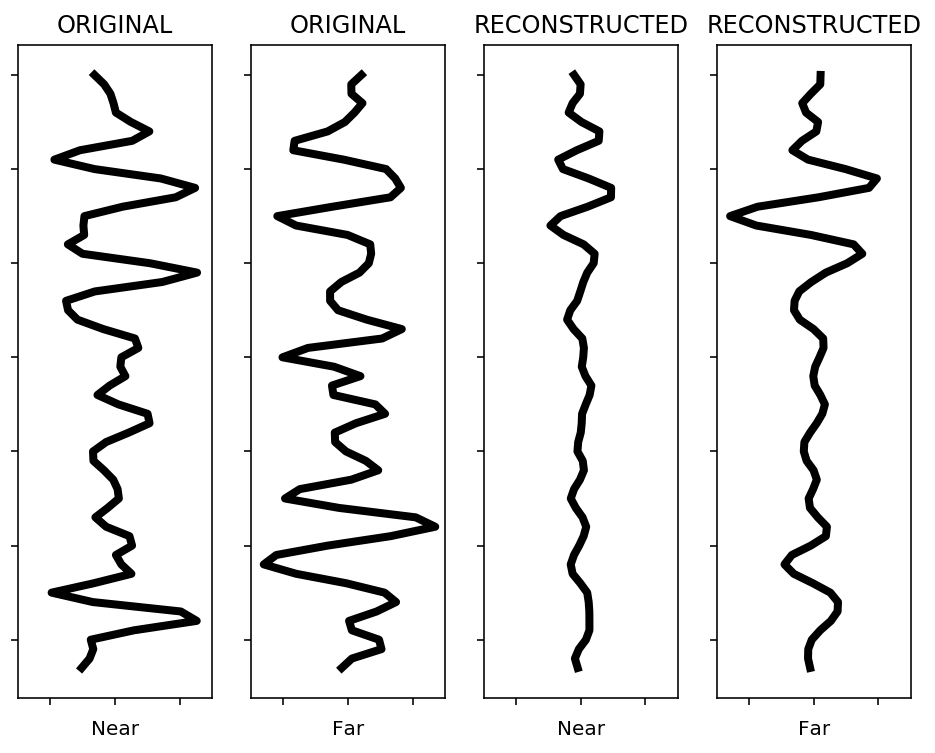

In [78]:
test_samples = np.load("test_out_49.npy")

opt={'linewidth':4, 'color':'black'}

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 6))
# real
ax[0].plot(test_samples[0,5,0,:], range(64), **opt) # near
ax[1].plot(test_samples[0,5,1,:], range(64), **opt) # far
# reconstructed
ax[2].plot(test_samples[1,5,0,:], range(64), **opt) # near
ax[3].plot(test_samples[1,5,1,:], range(64), **opt) # far
for aa in [ax[0],ax[2]]:
    aa.set_xlabel('Near')
for aa in [ax[1],ax[3]]:
    aa.set_xlabel('Far')
for aa in ax[:3]:
    aa.set_title('ORIGINAL')
for aa in ax[2:]:
    aa.set_title('RECONSTRUCTED')
for aa in ax:
    aa.set_yticklabels([])
    aa.set_xticklabels([])
    aa.invert_yaxis()
    aa.set_xlim(-3,3)
# plt.savefig('FIGS/original-reconstructed.png')

### references
    
* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).
    